# A new ml learning model predicting the RMSD value

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import sklearn.tree
import sklearn
import pickle
import re
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, auc
from sklearn.model_selection import cross_val_score

In [2]:
#Paths
AF_prediction_path = Path("../ressources/AF_predictions").resolve()
AF_prediction_results = Path("../ressources/AF_predictions/AF_prediction_randomized_DMI_results.xlsx").resolve()
AF_prediction_metrics = Path("../ressources/AF_predictions/AF_metrics_all_structures.tsv").resolve()
AF_DMI_structures_folders = [Path("../ressources/AF_DMI_structures").resolve() / p for p in ['AF_DMI_structures1', 'AF_DMI_structures2', 'AF_DMI_structures3', "AF_DMI_mutated_structures"]]
AF_DDI_structures_path = Path("../ressources/AF_DDI_structures").resolve()
solved_DMI_structures_path = Path("../ressources/DMI_solved_structures_hydrogens").resolve()
solved_DDI_structures_path = Path("../ressources/DDI_solved_structures_hydrogens").resolve()

for p in [AF_prediction_results, AF_prediction_metrics, AF_DDI_structures_path, solved_DMI_structures_path, solved_DDI_structures_path] + AF_DMI_structures_folders:
    if not p.exists():
        print(f"{p} does not point to a valid path")

In [3]:
# Loading Data
dataAF = pd.read_csv(AF_prediction_path / "data_af.csv")
dataAF.index = dataAF["prediction_name"] + "_" + dataAF["model_id"]
dataAF["min_distance"] = dataAF["min_distance"].fillna(value=20)
print(dataAF.columns)
dataAF

Index(['project_name', 'prediction_name', 'run_id', 'chainA_length',
       'chainB_length', 'model_id', 'model_confidence',
       'chainA_intf_avg_plddt', 'chainB_intf_avg_plddt', 'intf_avg_plddt',
       'pDockQ', 'iPAE', 'num_chainA_intf_res', 'num_chainB_intf_res',
       'num_res_res_contact', 'num_atom_atom_contact', 'RMSD_domain',
       'num_align_atoms_domain', 'align_score_domain', 'num_align_resi_domain',
       'RMSD_backbone_peptide', 'RMSD_all_atom_peptide', 'known_motif_plddt',
       'DockQ', 'iRMS', 'LRMS', 'Fnonnat', 'num_mutation_in_motif', 'label',
       'structure_name', 'file', 'hbonds', 'salt_bridges', 'buried_area',
       'min_distance', 'hydrophobic_interactions', 'ELM_Instance', 'PDB_ID'],
      dtype='object')


,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,ELM_Instance,PDB_ID
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_0.pdb,9,0,613.651,6.063,0,DEG_APCC_KENBOX_2,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_1,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_1,0.871984,95.793846,73.986000,89.736111,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_1.pdb,9,0,580.310,6.083,0,DEG_APCC_KENBOX_2,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_2,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_2,0.760784,95.547501,57.906001,86.585239,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_2.pdb,10,0,662.104,6.072,3,DEG_APCC_KENBOX_2,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_3,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_3,0.413662,94.646667,21.510000,76.362500,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_3.pdb,2,0,398.498,5.417,0,DEG_APCC_KENBOX_2,4GGD
DEG_APCC_KENBOX_2_4GGD_ranked_4,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_4,0.359078,94.830001,19.753333,72.307001,...,1,DEG_APCC_KENBOX_2_4GGD,ranked_4.pdb,2,0,323.304,5.092,9,DEG_APCC_KENBOX_2,4GGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_0,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_0,0.298701,49.827778,73.161904,62.392307,...,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0.pdb,7,3,1617.382,5.591,56,D1PF18773_PF00071,2X19
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_1,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_1,0.246961,54.362000,76.415000,66.390909,...,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1.pdb,3,0,791.256,6.373,7,D1PF18773_PF00071,2X19
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_2,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_2,0.211579,52.651538,72.910908,61.937083,...,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2.pdb,2,1,882.547,7.906,11,D1PF18773_PF00071,2X19
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_3,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_3,0.211144,50.398334,78.798751,66.627144,...,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3.pdb,7,5,1020.896,4.628,44,D1PF18773_PF00071,2X19


In [6]:
X_columns = ["model_confidence", "chainA_intf_avg_plddt", "chainB_intf_avg_plddt", "intf_avg_plddt", "pDockQ", "iPAE", 
            "buried_area", "min_distance", "hbonds", "salt_bridges", "hydrophobic_interactions",
            "num_chainA_intf_res", "num_chainB_intf_res", "num_res_res_contact", "num_atom_atom_contact", "chainA_length", "chainB_length"]
dataAF_randomDMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "random minimal")]
dataAF_mutated1DMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "1")]
dataAF_mutated2DMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "2")]
dataAF_randomDDI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "approved minimal DDI", dataAF["num_mutation_in_motif"] == "random minimal DDI")]

dataAF_randomDMI = dataAF_randomDMI[dataAF_randomDMI["model_id"] == "ranked_0"]
dataAF_mutated1DMI = dataAF_mutated1DMI[dataAF_mutated1DMI["model_id"] == "ranked_0"]
dataAF_mutated2DMI = dataAF_mutated2DMI[dataAF_mutated2DMI["model_id"] == "ranked_0"]
dataAF_randomDDI = dataAF_randomDDI[dataAF_randomDDI["model_id"] == "ranked_0"]

#dataAF_randomDMI = dataAF_randomDMI.sort_values(by=["structure_name_hash", "model_id"])
#dataAF_mutated1DMI = dataAF_mutated1DMI.sort_values(by=["structure_name_hash", "model_id"])
#dataAF_mutated2DMI = dataAF_mutated2DMI.sort_values(by=["structure_name_hash", "model_id"])
#dataAF_randomDDI = dataAF_randomDDI.sort_values(by=["structure_name_hash", "model_id"])

print(dataAF_randomDMI.shape, dataAF_mutated1DMI.shape, dataAF_mutated2DMI.shape, dataAF_randomDDI.shape)


randomDMI_xy = train_test_split(dataAF_randomDMI[X_columns], dataAF_randomDMI["label"], test_size=0.2, random_state=2501, shuffle=True)
mutated1DMI_xy = train_test_split(dataAF_mutated1DMI[X_columns], dataAF_mutated1DMI["label"], test_size=0.2, random_state=2501, shuffle=True)
mutated2DMI_xy = train_test_split(dataAF_mutated2DMI[X_columns], dataAF_mutated2DMI["label"], test_size=0.2, random_state=2501, shuffle=True)
randomDDI_xy = train_test_split(dataAF_randomDDI[X_columns], dataAF_randomDDI["label"], test_size=0.2, random_state=2501, shuffle=True)

print("Random DMI: Train", randomDMI_xy[0].shape, "Test", randomDMI_xy[1].shape)
print("1 Mutation DMI: Train", mutated1DMI_xy[0].shape, "Test", mutated1DMI_xy[1].shape)
print("2 Mutation DMI: Train", mutated2DMI_xy[0].shape, "Test", mutated2DMI_xy[1].shape)
print("Random DDI: Train", randomDDI_xy[0].shape, "Test", randomDDI_xy[1].shape)


(267, 38) (267, 38) (267, 38) (91, 38)
Random DMI: Train (213, 17) Test (54, 17)
1 Mutation DMI: Train (213, 17) Test (54, 17)
2 Mutation DMI: Train (213, 17) Test (54, 17)
Random DDI: Train (72, 17) Test (19, 17)


In [12]:
dataAF_pairedDMI = dataAF[np.logical_and(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["model_id"] == "ranked_0")]
dataAF_pairedDMI = dataAF_pairedDMI[dataAF_pairedDMI["RMSD_all_atom_peptide"] < 20]
pariedDMI_xy = train_test_split(dataAF_pairedDMI[X_columns], dataAF_pairedDMI["RMSD_all_atom_peptide"], test_size=0.2, random_state=2501, shuffle=True)
print("Train", pariedDMI_xy[0].shape, "Test", pariedDMI_xy[1].shape)

Train (97, 17) Test (25, 17)


In [11]:
pariedDMI_xy[2]

LIG_FXI_DFP_1_5EOD_ranked_0       1.050600
LIG_RPA_C_VERT_1DPU_ranked_0      5.335791
DEG_SPOP_SBC_1_3HQM_ranked_0      1.686127
LIG_WW_1_1EG4_ranked_0            1.052220
LIG_OCRL_FANDH_1_3QIS_ranked_0    2.406165
                                    ...   
DEG_SCF_TIR1_1_2P1Q_ranked_0      7.114390
LIG_BIR_III_3_1JD5_ranked_0       1.323125
DOC_ANK_TNKS_1_3TWU_ranked_0      1.223509
LIG_SIN3_1_1PD7_ranked_0          2.984004
LIG_NRP_CENDR_1_2ORZ_ranked_0     5.768841
Name: RMSD_all_atom_peptide, Length: 97, dtype: float64

In [13]:
def Fit(name, data, fitFunc, params=None, columns=None, plot=False):
    x_train, x_test, y_train, y_test = data
    if columns is not None:
        x_train, x_test = x_train[columns], x_test[columns]

    model = fitFunc(x_train, y_train, *params)
    y_predict = model.predict(x_test)
    y_prob = model.predict_proba(x_test)

    score = accuracy_score(y_test, y_predict)
    roc_score = roc_auc_score(y_test, y_prob[:,1])
    roc_score_confidence = roc_auc_score(y_test, x_test["model_confidence"])
    roc_curvexy = roc_curve(y_test, y_prob[:,1])
    roc_curvexy_confidence = roc_curve(y_test, x_test["model_confidence"])

    print("Score:", score)
    print("ROC_AUC_score:", roc_score)
    display(model)

    _line2D = plt.plot(roc_curvexy[0], roc_curvexy[1], label=f"{name} ml prediction (AUC = {roc_score:.2f})")[0]
    c = np.array(colors.to_rgb(_line2D.get_color()))
    c1 = np.clip(1.2*c, a_max=1, a_min=None)
    c2 = 0.7*c
    _line2D.set_color(c1)
    plt.plot(roc_curvexy_confidence[0], roc_curvexy_confidence[1], label=f"{name} model confidence (AUC = {roc_score_confidence:.2f})", color=c2)
    
    if plot:
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve for Model and Test Subset Features")
        plt.legend(loc="lower right")
        plt.show()
    return model

In [14]:
def FitRandomForrest(x_train, y_train, param_distributions, n_iter=10, cv=None):
    rf = RandomForestClassifier(random_state=2501, n_estimators=200)
    rs = RandomizedSearchCV(n_iter=n_iter, estimator=rf, param_distributions=param_distributions, scoring="accuracy", n_jobs=-1, verbose=2, random_state=2501, cv=cv)
    rs.fit(x_train, y_train)
    return rs.best_estimator_

In [15]:
params = {
    "min_impurity_decrease" : [0, 0.05, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07],
    "max_features": ["sqrt", 4, 6, 8, 10, 12, 14],
    "max_depth": [None, 6, 8, 10, 12, 14, 16],
    "min_samples_split": [2,3,4,5,6],
    "max_leaf_nodes": [None, 10, 20, 40, 60, 80, 100]
}

## Trying a deep learning approach (it can't hurt)

In [17]:
from sklearn.neural_network import MLPClassifier

X = [[0., 0.], [1., 1.]]

y = [0, 1]

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,

                    hidden_layer_sizes=(5, 2), random_state=1)


clf.fit(X, y)
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [29]:
from sklearn.neural_network import MLPRegressor
x_train, x_test, y_train, y_test = pariedDMI_xy
clf = MLPRegressor(solver='lbfgs',  hidden_layer_sizes=(10, 5), random_state=2501, verbose=10)
clf.fit(x_train, y_train)

y_proba = clf.predict(x_test)

c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


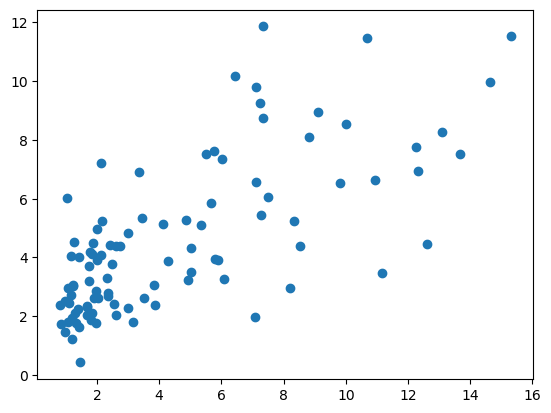

In [26]:
plt.scatter(y_train, clf.predict(x_train))